In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis

Last Date in Database: 2017-08-23
Query Start Date (1 Year): 2016-08-23 00:00:00


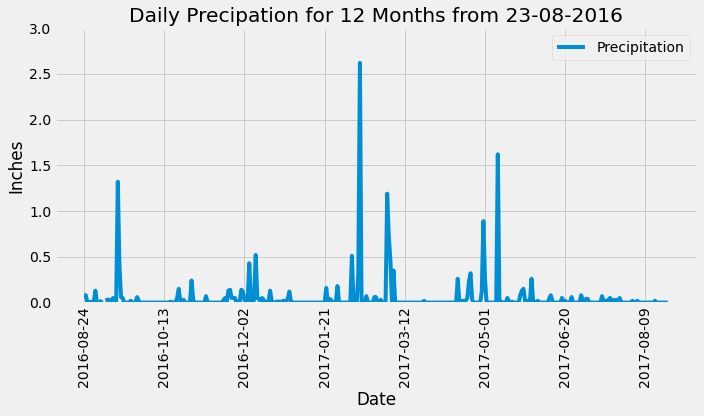

In [12]:
# Calculate the date 1 year ago from the last data point in the database

# Find most recent date in database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date, = last_date # Convert object to string
#Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data.

year_ago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
print(f"Last Date in Database: {last_date}")
print(f"Query Start Date (1 Year): {year_ago}")

# Ation_scores = session.query(Measurement.date, Measurement.prcp)\
                                    .filter(Measurement.date >= year_ago)\
                                    .group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation_scores)
prcp_df = prcp_df.set_index("date")

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
precipitation_plot = prcp_df.plot(ax=ax, title="Daily Precipation for 12 Months from 23-08-2016")
precipitation_plot.set_xlabel("Date")
precipitation_plot.set_ylabel("Inches")
precipitation_plot.legend(["Precipitation"])
plt.xticks(rotation=90)
plt.ylim(0,3)
plt.savefig("output/prcp.png")
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


### Station Analysis

In [14]:
#Design a query to calculate the total number of stations in the dataset.
station_count = session.query(Measurement.station)\
                .group_by(Measurement.station).count()
print(f"There are {station_count} stations in this dataset")

There are 9 stations in this dataset


In [15]:
#Design a query to find the most-active stations (that is, the stations that have the most rows). To do so, complete the following steps:
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())

for row in station_activity:
    print(row)

print(f"The most active station is {station_activity[0][0]}")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)
The most active station is USC00519281


In [16]:
#hich station id has the greatest number of observations?
#Design a query that calculates the lowest, highest, and average temperatures that filters on the most-active station id found in the previous query.
(lo,hi,av), = session.query(func.min(Measurement.tobs)\
                                        ,func.max(Measurement.tobs)\
                                        ,func.avg(Measurement.tobs))\
                                        .filter(Measurement.station == \
                                                station_activity[0][0]).all()

print(f"Temperature Observation Data for station {station_activity[0][0]}:\n\
{'-'*53}\n\
Lowest temperature recorded: {lo} F\n\
Highest temperature recorded: {hi} F\n\
Average temperature recorded: {round(av,1)} F")

Temperature Observation Data for station USC00519281:
-----------------------------------------------------
Lowest temperature recorded: 54.0 F
Highest temperature recorded: 85.0 F
Average temperature recorded: 71.7 F


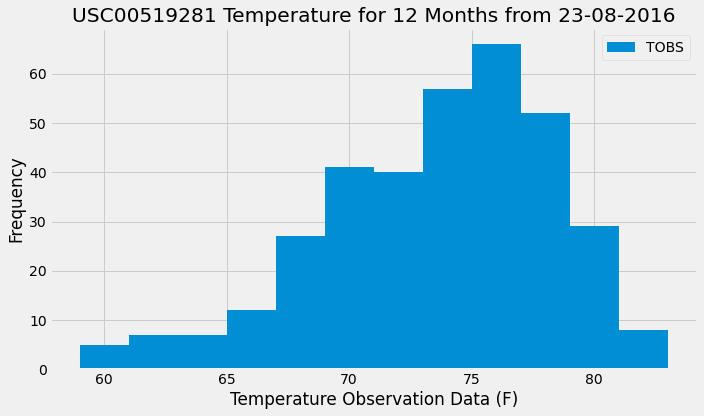

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_most_active_station = session.query(Measurement.date, Measurement.tobs)\
            .filter(Measurement.station == station_activity[0][0])\
            .filter(Measurement.date >= year_ago)\
            .all()

tobs_df = pd.DataFrame(tobs_most_active_station)
tobs_df = tobs_df.set_index("date")

fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
histogram = tobs_df.plot(ax=ax, kind="hist", bins=12, title=f"{station_activity[0][0]} Temperature for 12 Months from 23-08-2016")
histogram.set_xlabel("Temperature Observation Data (F)")
histogram.legend(["TOBS"])
plt.savefig("output/tobs.png")
plt.show()

In [18]:
#closing session
session.close()